# Voting systems

### Modeling elections as channels

We are gonna start with a simple example to set the scene. Consider the smallest election ever with just 3 voters and 2 candidates.  How can we model that using QIF terminology?

We know that a channel takes as input something secret and outputs something public. So what is secret in an election? The votes. But we have 3 persons voting. And each person has 2 possible options for his vote. So in total there are the following $2^3$ scenarios ($c_1$ and $c_2$ below stand for _candidate 1_ and _candidate 2_ respectively):

```
X = {
    c1 c1 c1, 
    c1 c1 c2, 
    c1 c2 c1, 
    c1 c2 c2, 
    c2 c1 c1, 
    c2 c1 c2, 
    c2 c2 c1, 
    c2 c2 c2, 
    }
```


And that is how we can model the votes as our channel's input $X$.

But what would the channel's output be? It depends. It could be just the name of the winning candidate; that is, the candidate which received the most votes. Or maybe it could be for each candidate, the votes they received. Or something else. For this example we are gonna examine channels that announce only the winner's name and nothing else. And the possible values for that output $Y$ are the candidates themselves, i.e.:

```
Y = { c1, c2 }
```

So for our example the complete channel would look like:

$$
\begin{array}{|c|c|c|}
\hline
W & c_1 & c_2 \\ \hline
c_1 c_1 c_1 & 1 & 0 \\ \hline
c_1 c_1 c_2 & 1 & 0 \\ \hline
c_1 c_2 c_1 & 1 & 0 \\ \hline
c_1 c_2 c_2 & 0 & 1 \\ \hline
c_2 c_1 c_1 & 1 & 0 \\ \hline
c_2 c_1 c_2 & 0 & 1 \\ \hline
c_2 c_2 c_1 & 0 & 1 \\ \hline
c_2 c_2 c_2 & 0 & 1 \\ \hline
\end{array}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from func import *
try:
    from qif import *
except: # install qif if not available (for running in colab, etc)
    import IPython; IPython.get_ipython().run_line_magic('pip', 'install qif')
    from qif import *

In [2]:
num_voters = 3
num_candidates = 2
num_combinations = num_candidates ** num_voters

In [3]:
W = get_W(num_voters, num_candidates)
print(W)

[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]


We also assume that there is no prior knowledge about which voter votes for which candidate, so we use a uniform prior.

In [4]:
pi = probab.uniform(num_combinations)
print(pi)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


If we take a look at the hyper distribution, we see that each result happens with the same probability and upon observing it, the possible voting combinations have also happen with the same probability.

In [5]:
from print_hyper import print_hyper
print_hyper(W, pi)

-------------------
|    0.50    0.50 |
-------------------
|    0.25    0.00 |
|    0.25    0.00 |
|    0.25    0.00 |
|    0.00    0.25 |
|    0.25    0.00 |
|    0.00    0.25 |
|    0.00    0.25 |
|    0.00    0.25 |
-------------------


So it is natural to expect that $W$'s vulnerability is $0.25$ that is, two times the channel's prior vulnerability (which was equal to $0.125$).

In [6]:
print("Prior bayes vulnerability:", measure.bayes_vuln.prior(pi))
print("Posterior bayes vulnerability:", measure.bayes_vuln.posterior(pi, W))
print("Multiplicative bayes leakage:", measure.bayes_vuln.mult_leakage(pi, W))

Prior bayes vulnerability: 0.125
Posterior bayes vulnerability: 0.25
Multiplicative bayes leakage: 2.0


But as someone might expect, these numbers get very small really fast as we consider more voters. That happens because the possible values for $X$, i.e.the voting combinations, grow exponentially to the number of voters. For example for an election of $10$ voters and $2$ candidates we have:

In [7]:
num_voters = 10
num_candidates = 2
num_combinations = num_candidates ** num_voters

In [8]:
print("Prior bayes vulnerability:", measure.bayes_vuln.prior(probab.uniform(num_combinations)))
print("Posterior bayes vulnerability:", measure.bayes_vuln.posterior(probab.uniform(num_combinations), get_W(num_voters, num_candidates)))
print("Multiplicative bayes leakage:", measure.bayes_vuln.mult_leakage(probab.uniform(num_combinations), get_W(num_voters, num_candidates)))

Prior bayes vulnerability: 0.0009765625
Posterior bayes vulnerability: 0.001953125
Multiplicative bayes leakage: 2.0


Let's see the bigger picture using a graph with the number of voters ranging from $1$ to $12$.

In [9]:
c = 2 # number of candidates
vs = [v for v in range(1, 12)]

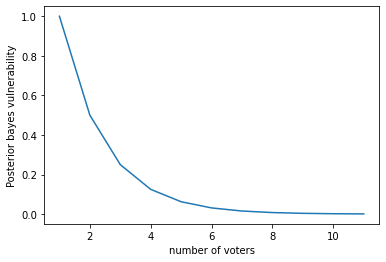

In [10]:
plt.plot(vs, [measure.bayes_vuln.posterior(probab.uniform(c ** v), get_W(v, c)) for v in vs])
plt.xlabel('number of voters')
plt.ylabel('Posterior bayes vulnerability')
None

Notice however that the leakage always stays equal to $2$. That is, $W$ doubles our probability of correctly guessing the voting combination that occured.

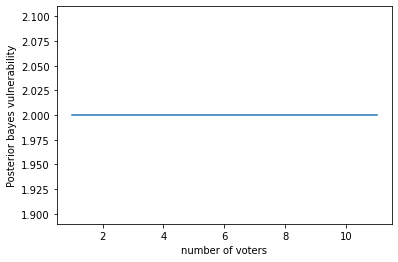

In [11]:
plt.plot(vs, [measure.bayes_vuln.mult_leakage(probab.uniform(c ** v), get_W(v, c)) for v in vs])
plt.xlabel('number of voters')
plt.ylabel('Posterior bayes vulnerability')
None

But the posterior vulnerability drops down to $0$ very fast, so from around $5$ voters or more we could argue that our secret is safe. **But safe against who?** Until now we used Bayes Vulnerability which corresponds to an adversary trying to correctly guess _the whole voting combination_ that occured. But that is usually not the case. More on part 2.